In [2]:
# Select Environment(conda_kipoi-shared__env__kipoi-py3-keras2)
import kipoi
import torch
import scipy.io
import time
import numpy as np
import h5py
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

import kipoi_interpret
from kipoi_veff.utils.plot import seqlogo_heatmap
from concise.preprocessing.sequence import encodeDNA
# Gradient-based methods
from kipoi_interpret.importance_scores.gradient import Gradient, GradientXInput
# In-silico mutagenesis-based methods
from kipoi_interpret.importance_scores.ism import Mutation

In [3]:
### checks
# kipoi.list_models()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


In [4]:
### set the path
data_dir = 'data/deepsea_train/'
result_dir = 'out/'

### Load train/test dataset

In [5]:
tic = time.time()
test_mat = scipy.io.loadmat(data_dir + 'test.mat')
Y_test = torch.FloatTensor(test_mat['testdata'])
X_test = torch.FloatTensor(test_mat['testxdata'])
toc = time.time()
print(round(toc - tic), 'sec elapsed')

20 sec elapsed


In [6]:
print(X_test.shape, Y_test.shape)

torch.Size([455024, 4, 1000]) torch.Size([455024, 919])


In [7]:
# reshape X_test
X_test = torch.reshape(X_test, (455024, 4, 1, 1000))
X_test.shape

torch.Size([455024, 4, 1, 1000])

### EDA: test X

In [8]:
X_test.shape

torch.Size([455024, 4, 1, 1000])

In [9]:
test_seqs = np.zeros((X_test.shape[0], X_test.shape[3]))
for i in tqdm(range(test_seqs.shape[0])):
    test_seqs[i, :] = X_test[i, :, 0, :].max(axis = 0).indices.numpy()
test_seqs.shape

100%|██████████| 455024/455024 [00:26<00:00, 17487.92it/s]


(455024, 1000)

In [10]:
test_seqs[:10, :10]

array([[0., 3., 2., 3., 0., 0., 0., 0., 2., 3.],
       [1., 2., 3., 1., 0., 1., 1., 2., 0., 1.],
       [2., 1., 1., 1., 3., 1., 2., 2., 1., 3.],
       [2., 0., 1., 2., 0., 1., 2., 3., 2., 0.],
       [1., 1., 2., 0., 1., 3., 1., 3., 2., 2.],
       [3., 1., 1., 0., 1., 2., 3., 2., 3., 1.],
       [2., 2., 0., 1., 2., 3., 3., 1., 1., 2.],
       [0., 3., 0., 0., 0., 3., 0., 0., 0., 3.],
       [1., 0., 2., 3., 1., 2., 2., 1., 3., 2.],
       [2., 0., 1., 3., 2., 0., 2., 0., 2., 1.]])

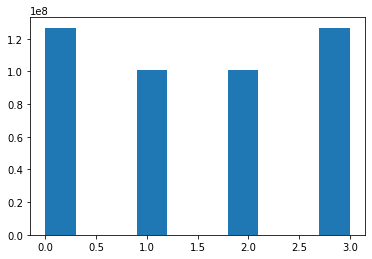

In [11]:
plt.hist(test_seqs.flatten())
plt.show()

In [12]:
1.2 * 1e8 / len(test_seqs.flatten())

0.2637223531066493

### EDA: test Y

In [13]:
Y_test.shape

torch.Size([455024, 919])

In [14]:
Y_test[:10, :]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [15]:
Y_test_np = Y_test.numpy()

In [16]:
np.unique(Y_test_np.flatten())

array([0., 1.], dtype=float32)

In [17]:
pos_prop = Y_test_np.mean(axis = 0)

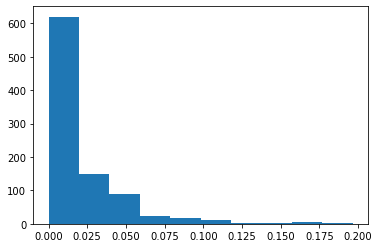

In [18]:
plt.hist(pos_prop)
plt.show()

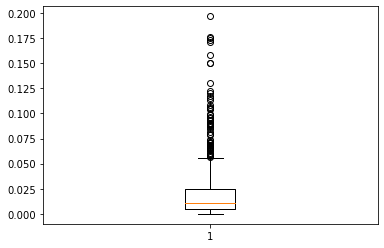

In [19]:
plt.boxplot(pos_prop)
plt.show()

In [20]:
np.quantile(pos_prop, [0, .25, .5, .75, .1])

array([0.        , 0.00460635, 0.01114666, 0.02519867, 0.00143201])

In [21]:
(pos_prop == 0).sum()

1